# Enhancing Fake News Detection Accuracy and Interpretability: Combining Historical Credibility Scores with Explainable AI

## Introduction

This notebook implements the core components of a fake news detection system, focusing on enhancing detection accuracy and interpretability by integrating historical credibility scores with Explainable AI techniques. The steps include loading the enhanced LIAR-PLUS dataset, preprocessing, feature extraction, model development, and interpretability analysis using SHAP. By emphasizing both accuracy and explainability, the system aims to provide not only reliable predictions but also transparent insights into the modle's decision-making process.



## 1. Dataset Loading and Preprocessing

### Dataset Loading

The LIAR-PLUS dataset [Alhindi et al., 2018], an extension of the LIAR dataset [Wang, 2017], comprises 12.8K manually labeled short statements from politifact.com, annotated for truthfulness. This dataset includes statement content, speaker details, context, and credibility labels, along with justifications provided by human fact-checkers. These justifications offer valuable context, enabling the development of models that are both accurate and explainable.

First, we load three distinct datasets—training, testing, and validation—each playing a critical role in developing and evaluating our model. After loading, we organize the data into pandas DataFrames to make it easier to work with later. This step prepares the data for the upcoming stages, where we’ll clean and refine it for further analysis.


In [1]:
from IPython.display import display, HTML
import pandas as pd
import json

# Define column names based on the provided sample
all_columns = ['label', 'claim', 'topics', 'originator', 'title', 'party', 'justification']
text_columns = ['claim', 'originator', 'title', 'party', 'justification']

# Load the JSONL datasets
def load_jsonl(file_path, columns):
    with open(file_path, 'r') as file:
        data = [json.loads(line) for line in file]
    return pd.DataFrame(data, columns=columns)

train_df = load_jsonl('train2.jsonl', all_columns)
test_df = load_jsonl('test2.jsonl', all_columns)
val_df = load_jsonl('val2.jsonl', all_columns)

# Show a brief summary of the dataset
display(train_df.info())
display(train_df.describe())
display(train_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10269 entries, 0 to 10268
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          10269 non-null  object
 1   claim          10269 non-null  object
 2   topics         10269 non-null  object
 3   originator     10269 non-null  object
 4   title          10269 non-null  object
 5   party          10269 non-null  object
 6   justification  10238 non-null  object
dtypes: object(7)
memory usage: 561.7+ KB


None

label                                              claim  \
count       10269                                              10269   
unique          6                                              10252   
top     half-true  On changing the rules for filibusters on presi...   
freq         2123                                                  3   

               topics    originator  title  party justification  
count           10269         10269  10269  10269         10238  
unique           3836          2916   1188     85         10146  
top     [health-care]  barack-obama                          \n  
freq              382           493   2901   2209            84

label                                              claim  \
0            false  Says the Annies List political group supports ...   
1        half-true  When did the decline of coal start? It started...   
2      mostly-true  "Hillary Clinton agrees with John McCain ""by ...   
3            false  Health care reform legislation is likely to ma...   
4        half-true  The economic turnaround started at the end of ...   
...            ...                                                ...   
10264  mostly-true  There are a larger number of shark attacks in ...   
10265  mostly-true  Democrats have now become the party of the [At...   
10266    half-true  Says an alternative to Social Security that op...   
10267        false  On lifting the U.S. Cuban embargo and allowing...   
10268   pants-fire  The Department of Veterans Affairs has a manua...   

                                       topics      originator  \
0                                  [abortion]    dwayne-bohac   
1      [energy, history, job-accomplishments]  scott-surovell   
2                            [foreign-policy]    barack-obama   
3                               [health-care]    blog-posting   
4                             [economy, jobs]   charlie-crist   
...                                       ...             ...   
10264                    [animals, elections]    aclu-florida   
10265                             [elections]     alan-powell   
10266           [retirement, social-security]     herman-cain   
10267               [florida, foreign-policy]     jeff-greene   
10268                 [health-care, veterans]  michael-steele   

                                               title     party  \
0                               State representative     Texas   
1                                     State delegate  Virginia   
2                                          President  Illinois   
3                                                                
4                                                      Florida   
...                                              ...       ...   
10264                                                  Florida   
10265                                                  Georgia   
10266                                                  Georgia   
10267                                                  Florida   
10268  chairman of the Republican National Committee  Maryland   

                                           justification  
0      That's a premise that he fails to back up. Ann...  
1      "Surovell said the decline of coal ""started w...  
2      "Obama said he would have voted against the am...  
3      "The release may have a point that Mikulskis c...  
4      "Crist said that the economic ""turnaround sta...  
...                                                  ...  
10264  They compounded their error by combining full ...  
10265  "Romney said that ""Obamacare  means that for ...  
10266  "But that it leaves out important details and ...  
10267  We checked the research and, quite frankly, fi...  
10268  "Krueger said that ""since the Affordable Care...  

[10269 rows x 7 columns]

### Exploratory Data Analysis

After loading the dataset, we conduct an exploratory data analysis (EDA) to better understand its structure and content. This step is crucial for identifying any potential issues and gaining insights that will guide the subsequent stages of model development.


#### Visualizing Label Distribution

To further understand the dataset, we visualize the distribution of truthfulness labels within the training data. This analysis is important for detecting class imbalances, which can impact the performance of the machine learning model.


In [2]:
import plotly.express as px

label_distribution = train_df['label'].value_counts().reset_index()
label_distribution.columns = ['label', 'count']

# Create the interactive pie chart
fig = px.pie(label_distribution, values='count', names='label', title='Distribution of Truthfulness Labels',
             color_discrete_sequence=px.colors.qualitative.Pastel)

# Update the layout to make the hover more informative
fig.update_traces(textposition='inside', textinfo='percent+label')

# Show the interactive chart
fig.show()


#### Class Imbalance Detection

Given that class imbalance can heavily influence model performance, we calculate the class weights to understand the imbalance better. This information is critical for deciding whether to apply techniques like class weighting, oversampling, or undersampling during model training.


In [3]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_dict = dict(zip(np.unique(train_df['label']), class_weights))

display(pd.DataFrame(list(class_weights_dict.items()), columns=['Label', 'Class Weight']))


Label  Class Weight
0  barely-true      1.032891
1        false      0.856607
2    half-true      0.806171
3  mostly-true      0.870549
4   pants-fire      2.032660
5         true      1.016934

#### Text Length Distribution

Analyzing the distribution of claim lengths helps us determine whether the length of a claim influences its classification. This analysis can also highlight outliers that may require special attention during preprocessing.


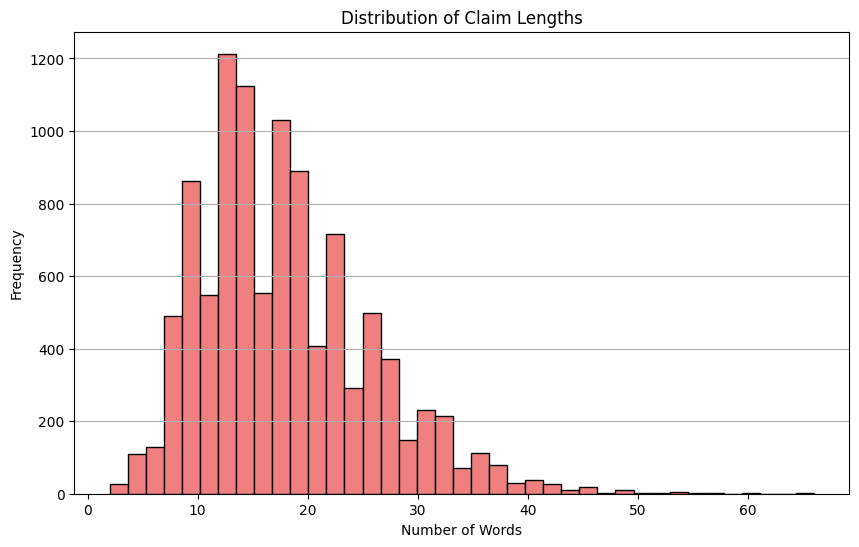

In [4]:
import matplotlib.pyplot as plt

# Calculate the length of each claim
train_df['claim_length'] = train_df['claim'].apply(lambda x: len(x.split()))

# Plot the distribution of claim lengths
plt.figure(figsize=(10, 6))
plt.hist(train_df['claim_length'], bins=np.linspace(train_df['claim_length'].min(), train_df['claim_length'].max(), 40), color='lightcoral', edgecolor='black')
plt.title('Distribution of Claim Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()


### Data Cleaning

Ensuring data integrity is crucial before proceeding with text preprocessing and feature extraction. In this step, we clean the dataset by removing any rows with missing (`NaN`) values or empty strings. These problematic entries can introduce noise or bias, which could negatively impact model performance.

We implement a `filter_problematic_rows` function to systematically remove these entries across the training, testing, and validation datasets to maintain consistency. Once the cleaning process is complete, we inspect the cleaned datasets to verify the removal of problematic rows and ensure that the data is ready for subsequent preprocessing steps.


In [5]:
# Function to filter out rows with NaN values or empty string values
def filter_problematic_rows(df):
    return df.dropna().loc[~df.applymap(lambda x: x == '' if isinstance(x, str) else False).any(axis=1)]

# Filter out problematic rows in all DataFrames
train_df = filter_problematic_rows(train_df)
test_df = filter_problematic_rows(test_df)
val_df = filter_problematic_rows(val_df)

# Display the cleaned datasets
display(train_df.info())
display(train_df)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6795 entries, 0 to 10268
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          6795 non-null   object
 1   claim          6795 non-null   object
 2   topics         6795 non-null   object
 3   originator     6795 non-null   object
 4   title          6795 non-null   object
 5   party          6795 non-null   object
 6   justification  6795 non-null   object
 7   claim_length   6795 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 477.8+ KB


None

label                                              claim  \
0            false  Says the Annies List political group supports ...   
1        half-true  When did the decline of coal start? It started...   
2      mostly-true  "Hillary Clinton agrees with John McCain ""by ...   
5             true  The Chicago Bears have had more starting quart...   
7        half-true  I'm the only person on this stage who has work...   
...            ...                                                ...   
10256   pants-fire  Recently though, the media has reported on tho...   
10257  barely-true  Stopped by Smiley Cookie to pick up some great...   
10259  barely-true  The Supreme Courts views are radically out of ...   
10260    half-true  When it comes to the state deficit, Wisconsin ...   
10268   pants-fire  The Department of Veterans Affairs has a manua...   

                                          topics       originator  \
0                                     [abortion]     dwayne-bohac   
1         [energy, history, job-accomplishments]   scott-surovell   
2                               [foreign-policy]     barack-obama   
5                                    [education]        robin-vos   
7                                       [ethics]     barack-obama   
...                                          ...              ...   
10256                                [elections]    john-rafferty   
10257                                     [food]     donald-trump   
10259  [gays-and-lesbians, polls, supreme-court]         ted-cruz   
10260                             [state-budget]  alberta-darling   
10268                    [health-care, veterans]   michael-steele   

                                               title         party  \
0                               State representative         Texas   
1                                     State delegate      Virginia   
2                                          President      Illinois   
5                         Wisconsin Assembly speaker     Wisconsin   
7                                          President      Illinois   
...                                              ...           ...   
10256                                  State Senator  Pennsylvania   
10257                                President-Elect      New York   
10259                                        Senator         Texas   
10260                    State Senator, 8th District     Wisconsin   
10268  chairman of the Republican National Committee      Maryland   

                                           justification  claim_length  
0      That's a premise that he fails to back up. Ann...            11  
1      "Surovell said the decline of coal ""started w...            24  
2      "Obama said he would have voted against the am...            19  
5      "But Vos specifically used the word ""fired,""...            27  
7      However, it was not that bill, but another one...            27  
...                                                  ...           ...  
10256  "And we could find no record of it. Our rating...            15  
10257  "Ross said, ""Every day, a black name resume i...            16  
10259  "Scott said, ""Over the past two years, Florid...            20  
10260  "McAuliffe said the $2. 4 billion budget short...            19  
10268  "Krueger said that ""since the Affordable Care...            30  

[6795 rows x 8 columns]

After cleaning, the training dataset now contains 6,795 entries, with all columns free of null values, confirming data integrity.


### Text Preprocessing

To ensure consistency and remove noise, we preprocess the text data by applying normalization, tokenization, lemmatization, and stop word removal. This standardizes the text data, improving feature extraction and model performance. We apply this preprocessing pipeline to relevant text columns across the training, testing, and validation datasets.


In [6]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text):

    # Normalization
    text = str(text).lower()

    text = re.sub(r'[^a-zA-Z\s-]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop Words Removal
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in lemmas if word not in stop_words]

    return ' '.join(filtered_text)


# Apply preprocessing to specified text columns
def apply_text_preprocessing(df, columns):
    for column in columns:
        df[column] = df[column].apply(preprocess_text)
    return df

# Preprocess each text column
train_df = apply_text_preprocessing(train_df, text_columns)
test_df = apply_text_preprocessing(test_df, text_columns)
val_df = apply_text_preprocessing(val_df, text_columns)

display(train_df)


[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/runner/nltk_data...
[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


label                                              claim  \
0            false  say annies list political group support third-...   
1        half-true  decline coal start started natural gas took st...   
2      mostly-true  hillary clinton agrees john mccain voting give...   
5             true  chicago bear starting quarterback last year to...   
7        half-true  im person stage ha worked actively last year p...   
...            ...                                                ...   
10256   pants-fire  recently though medium ha reported thousand il...   
10257  barely-true  stopped smiley cookie pick great cooky family ...   
10259  barely-true  supreme court view radically step public opini...   
10260    half-true  come state deficit wisconsin proportionally mu...   
10268   pants-fire  department veteran affair ha manual telling ve...   

                                          topics       originator  \
0                                     [abortion]     dwayne-bohac   
1         [energy, history, job-accomplishments]   scott-surovell   
2                               [foreign-policy]     barack-obama   
5                                    [education]        robin-vos   
7                                       [ethics]     barack-obama   
...                                          ...              ...   
10256                                [elections]    john-rafferty   
10257                                     [food]     donald-trump   
10259  [gays-and-lesbians, polls, supreme-court]         ted-cruz   
10260                             [state-budget]  alberta-darling   
10268                    [health-care, veterans]   michael-steele   

                                        title         party  \
0                        state representative         texas   
1                              state delegate      virginia   
2                                   president      illinois   
5                  wisconsin assembly speaker     wisconsin   
7                                   president      illinois   
...                                       ...           ...   
10256                           state senator  pennsylvania   
10257                         president-elect      new york   
10259                                 senator         texas   
10260               state senator th district     wisconsin   
10268  chairman republican national committee      maryland   

                                           justification  claim_length  
0      thats premise fails back annies list make bone...            11  
1      surovell said decline coal started natural gas...            24  
2      obama said would voted amendment present thoug...            19  
5      vos specifically used word fired mean faculty ...            27  
7      however wa bill another one sponsored majority...            27  
...                                                  ...           ...  
10256  could find record rating kaleka said wisconsin...            15  
10257  ross said every day black name resume percent ...            16  
10259  scott said past two year florida ha cut billio...            20  
10260  mcauliffe said billion budget shortfall lawmak...            19  
10268  krueger said since affordable care act passed ...            30  

[6795 rows x 8 columns]

After preprocessing, we display the first few entries of the training dataset to verify that the text has been cleaned and standardized. This step is crucial for ensuring the data is ready for feature extraction and subsequent model training, reducing model complexity and improving accuracy.


---

## 2. Calculating Credibility Scores

To complement the textual features, we calculate speaker credibility scores based on the historical truthfulness of their statements. This step enhances the model’s ability to factor in the reliability of the information source, aligning with our objective of improving both accuracy and interpretability. The scores are mapped to labels on a scale from 0 (least truthful) to 1.0 (most truthful), reflecting the degree of truthfulness associated with each label.


In [7]:
# Define the label to score mapping
label_to_score = {
    'pants-fire': 0,
    'false': 0.2,
    'barely-true': 0.4,
    'half-true': 0.6,
    'mostly-true': 0.8,
    'true': 1.0
}


def calculate_credibility(df, label_to_score):
    df['label_score'] = df['label'].map(label_to_score)
    credibility_scores = df.groupby('originator')['label_score'].mean()
    return credibility_scores


# Calculate the speaker credibility scores for each dataset individually
train_credibility_scores = calculate_credibility(train_df, label_to_score)
test_credibility_scores = calculate_credibility(test_df, label_to_score)
val_credibility_scores = calculate_credibility(val_df, label_to_score)


# Map the scores back to each dataset individually
train_df['credibility_score'] = train_df['originator'].map(train_credibility_scores)
test_df['credibility_score'] = test_df['originator'].map(test_credibility_scores)
val_df['credibility_score'] = val_df['originator'].map(val_credibility_scores)


# Display the updated train_df
display(train_df.head())


label                                              claim  \
0        false  say annies list political group support third-...   
1    half-true  decline coal start started natural gas took st...   
2  mostly-true  hillary clinton agrees john mccain voting give...   
5         true  chicago bear starting quarterback last year to...   
7    half-true  im person stage ha worked actively last year p...   

                                   topics      originator  \
0                              [abortion]    dwayne-bohac   
1  [energy, history, job-accomplishments]  scott-surovell   
2                        [foreign-policy]    barack-obama   
5                             [education]       robin-vos   
7                                [ethics]    barack-obama   

                        title      party  \
0        state representative      texas   
1              state delegate   virginia   
2                   president   illinois   
5  wisconsin assembly speaker  wisconsin   
7                   president   illinois   

                                       justification  claim_length  \
0  thats premise fails back annies list make bone...            11   
1  surovell said decline coal started natural gas...            24   
2  obama said would voted amendment present thoug...            19   
5  vos specifically used word fired mean faculty ...            27   
7  however wa bill another one sponsored majority...            27   

   label_score  credibility_score  
0          0.2           0.200000  
1          0.6           0.600000  
2          0.8           0.650000  
5          1.0           0.527273  
7          0.6           0.650000

### Visualizing Credibility Scores

To better understand the distribution of the calculated credibility scores, we plot a histogram. This visualization helps to assess how the credibility scores are distributed across the dataset, which is important for understanding how these scores might influence the model’s predictions.


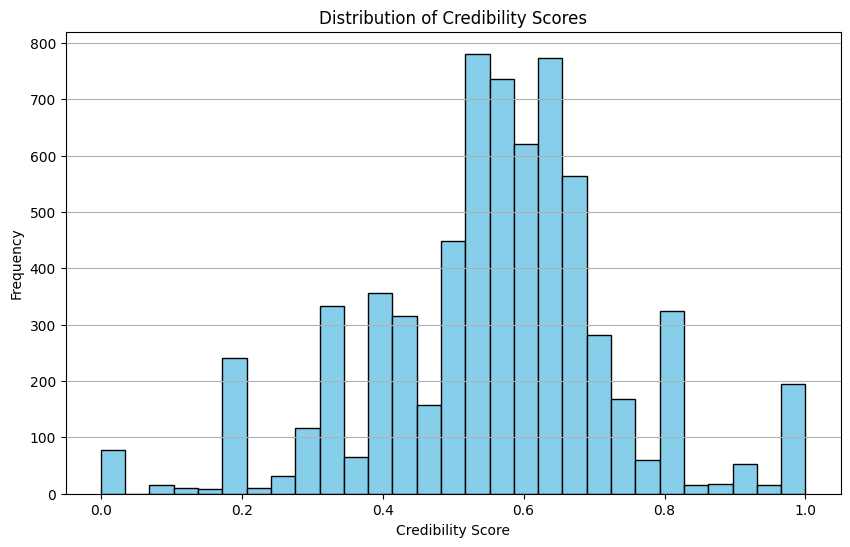

In [8]:
# Plotting the distribution of credibility scores
plt.figure(figsize=(10, 6))
plt.hist(train_df['credibility_score'], bins=np.linspace(0, 1, 30), color='skyblue', edgecolor='black')
plt.title('Distribution of Credibility Scores')
plt.xlabel('Credibility Score')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.show()


**The following observations can be made based on the distribution of credibility scores:**

- **Central Tendency —** The distribution peaks between 0.5 and 0.6, where most originators have credibility scores, indicating moderate truthfulness.

- **Distribution Spread —** Although the distribution spans nearly all bins, there is a pronounced concentration between 0.5 and 0.6, suggesting a balanced mix of truthfulness and falsity.

- **Low and High Extremes —** Distinct clusters at both low and high ends represent consistently unreliable or highly credible originators, highlighting variability in source reliability.

- **Gaps and Low Frequencies —** Certain bins have low counts or gaps, suggesting fewer originators with scores in these intervals, indicating distinct groupings in the data.

The balanced spread of credibility scores, with a central tendency, enhances the model's ability to identify subtle differences in source reliability, potentially improving accuracy and interpretability. Additionally, the presence of outliers provides an opportunity for the model to learn from extreme cases, further refining its predictive power.



---

## 3. Data Subset for Prototyping

Before moving to model training, a subset of the data is selected for initial experiments. This allows for quicker iterations and testing of the modeling pipeline, ensuring everything functions correctly before scaling up to the full dataset. 


In [9]:
# Select a subset of the data
subset_size = 500

X_train_subset = train_df[:subset_size].reset_index(drop=True)
y_train_subset = train_df['label'][:subset_size].reset_index(drop=True)

X_val_subset = val_df[:subset_size].reset_index(drop=True)
y_val_subset = val_df['label'][:subset_size].reset_index(drop=True)

X_test_subset = test_df[:subset_size].reset_index(drop=True)
y_test_subset = test_df['label'][:subset_size].reset_index(drop=True)

display(X_train_subset)
display(y_train_subset)


label                                              claim  \
0          false  say annies list political group support third-...   
1      half-true  decline coal start started natural gas took st...   
2    mostly-true  hillary clinton agrees john mccain voting give...   
3           true  chicago bear starting quarterback last year to...   
4      half-true  im person stage ha worked actively last year p...   
..           ...                                                ...   
495  mostly-true  say president barack obama promised pathway ci...   
496  mostly-true  california ha robust job growth outpaces rest ...   
497    half-true  amount debt pace double five year triple feder...   
498  barely-true  richardson-denish administration gave driver l...   
499         true  youre mexican get sent back youre noncontiguou...   

                                                topics       originator  \
0                                           [abortion]     dwayne-bohac   
1               [energy, history, job-accomplishments]   scott-surovell   
2                                     [foreign-policy]     barack-obama   
3                                          [education]        robin-vos   
4                                             [ethics]     barack-obama   
..                                                 ...              ...   
495  [children, families, homeland-security, immigr...   reince-priebus   
496            [climate-change, economy, energy, jobs]    kevin-de-leon   
497                                   [federal-budget]    bob-mcdonnell   
498                     [immigration, message-machine]  susana-martinez   
499              [children, human-rights, immigration]    henry-cuellar   

                                      title       party  \
0                      state representative       texas   
1                            state delegate    virginia   
2                                 president    illinois   
3                wisconsin assembly speaker   wisconsin   
4                                 president    illinois   
..                                      ...         ...   
495  chairman republican national committee   wisconsin   
496                california senate leader  california   
497                                governor    virginia   
498           candidate governor new mexico  new mexico   
499                        u representative       texas   

                                         justification  claim_length  \
0    thats premise fails back annies list make bone...            11   
1    surovell said decline coal started natural gas...            24   
2    obama said would voted amendment present thoug...            19   
3    vos specifically used word fired mean faculty ...            27   
4    however wa bill another one sponsored majority...            27   
..                                                 ...           ...   
495  zepecki cited obamas executive order rating pr...            21   
496  state senator kevin de len said earlier month ...            12   
497  current gross debt trillion presto chango carr...            25   
498  third denish supported measure wa enacted ad c...            13   
499  cuellar said unaccompanied alien child contigu...            29   

     label_score  credibility_score  
0            0.2           0.200000  
1            0.6           0.600000  
2            0.8           0.650000  
3            1.0           0.527273  
4            0.6           0.650000  
..           ...                ...  
495          0.8           0.442105  
496          0.8           0.800000  
497          0.6           0.578378  
498          0.4           0.400000  
499          1.0           0.700000  

[500 rows x 10 columns]

0            false
1        half-true
2      mostly-true
3             true
4        half-true
          ...     
495    mostly-true
496    mostly-true
497      half-true
498    barely-true
499           true
Name: label, Length: 500, dtype: object

**Subsetting Strategy:**

- **Computational Efficiency —** A subset size of 500 is selected to balance the need for quick iteration while having enough data points to yield meaningful insights during initial testing.

- **Index Reset —** The `reset_index(drop=True)` method is applied to ensure that indices in the subsets start at 0. This prevents misalignment issues during data processing, which is crucial for maintaining consistency across different stages of the modeling pipeline.


### Combining Preprocessed Text Columns

To prepare our data for vectorization and subsequent model training, we consolidate all preprocessed text columns into a single text column for each dataset entry. This step simplifies the input format for our models, allowing them to process each text entry as a single data point.


In [10]:
def combine_text_columns(df, columns):
    return df.apply(lambda row: ' '.join([str(val) for val in row[columns]]), axis=1)

# Combine the text columns for each row ensuring all values are converted to strings
X_train_textual_features = combine_text_columns(X_train_subset, text_columns)
X_test_textual_features = combine_text_columns(X_test_subset, text_columns)
X_val_textual_features = combine_text_columns(X_val_subset, text_columns)


---

## 4. Feature Extraction & Engineering

### TF-IDF Vectorization

The following code applies TF-IDF vectorization to the preprocessed textual features, converting the text data into numerical representations with a maximum of 1000 features. The vectorizer is first fit on the training data and then used to transform the validation and test sets, ensuring consistent feature extraction across datasets. Finally, the shapes of the resulting matrices are printed to confirm that the vectorization has been applied correctly, with each matrix representing the top 1000 terms across all samples.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
max_features_tfidf = 1000
tfidf_vectorizer = TfidfVectorizer(max_features=max_features_tfidf)

# Fit and transform the vectorizer on data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_textual_features)
X_test_tfidf = tfidf_vectorizer.transform(X_test_textual_features)
X_val_tfidf = tfidf_vectorizer.transform(X_val_textual_features)

# Print the shape of the resulting matrices
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(X_val_tfidf.shape)


(500, 1000)
(500, 1000)
(500, 1000)


### Feature Name Extraction

The TF-IDF feature names from the training subset are retrieved here. Printing the first 10 feature names offers an early glimpse into the key terms that the model will consider, which is essential for later stages where these names are used in model interpretability, such as in SHAP visualizations.


In [12]:
# Get feature and class names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names_with_scores = np.append(tfidf_feature_names, 'credibility_score')

# Print top 10 features
print("Feature names: ", tfidf_feature_names[:10])


Feature names:  ['abbott' 'ability' 'able' 'abortion' 'according' 'account' 'accurate'
 'accurately' 'acknowledged' 'across']


### TF-IDF Sparse Matrix Conversion

This section integrates the credibility scores with the TF-IDF features, enhancing the model’s ability to factor in source reliability. The credibility scores are reshaped and combined with the dense TF-IDF matrices, which are then converted back to a sparse format for computational efficiency. The matrix shapes are checked to confirm the correct addition of this new feature, which is expected to improve model performance by leveraging historical trustworthiness in predictions.


In [13]:
from scipy.sparse import csr_matrix

credibility_score_train = X_train_subset['credibility_score'].values.reshape(-1, 1)
credibility_score_test = X_test_subset['credibility_score'].values.reshape(-1, 1)
credibility_score_val = X_val_subset['credibility_score'].values.reshape(-1, 1)


# Combine the dense TF-IDF matrices with the originator scores
X_train_dense_with_scores = X_train_dense_with_scores if 'X_train_dense_with_scores' in locals() else np.hstack((X_train_tfidf.toarray(), credibility_score_train))
X_test_dense_with_scores = X_test_dense_with_scores if 'X_test_dense_with_scores' in locals() else np.hstack((X_test_tfidf.toarray(), credibility_score_test))
X_val_dense_with_scores = X_val_dense_with_scores if 'X_val_dense_with_scores' in locals() else np.hstack((X_val_tfidf.toarray(), credibility_score_val))


# Convert the combined dense matrices back to sparse format
X_train_tfidf_with_scores = csr_matrix(X_train_dense_with_scores)
X_test_tfidf_with_scores = csr_matrix(X_test_dense_with_scores)
X_val_tfidf_with_scores = csr_matrix(X_val_dense_with_scores)


# Convert the sparse TF-IDF matrices to dense format
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()
X_val_tfidf_dense = X_val_tfidf.toarray()

X_train_tfidf_dense_with_scores = X_train_tfidf_with_scores.toarray()
X_test_tfidf_dense_with_scores = X_test_tfidf_with_scores.toarray()
X_val_tfidf_dense_with_scores = X_val_tfidf_with_scores.toarray()


# Print the shape of the resulting matrices
print(X_train_tfidf.shape)  # Expected output: (500, 1000)
print(X_test_tfidf.shape)   # Expected output: (500, 1000)
print(X_val_tfidf.shape)    # Expected output: (500, 1000)

print()

print(X_train_tfidf_with_scores.shape)  # Expected output: (500, 1001)
print(X_test_tfidf_with_scores.shape)   # Expected output: (500, 1001)
print(X_val_tfidf_with_scores.shape)    # Expected output: (500, 1001)


(500, 1000)
(500, 1000)
(500, 1000)

(500, 1001)
(500, 1001)
(500, 1001)


---

## 5. Model Development and Evaluation

### Model Training

In this step, we initialize and train two Random Forest models to assess the impact of integrating credibility scores on fake news detection:

- **Baseline Model —** Trained using only TF-IDF features, this model serves as a reference for traditional text-based classification.

- **Enhanced Model —** This model incorporates both TF-IDF features and credibility scores, allowing it to account for the historical reliability of the information source.

By comparing these models, we aim to determine if the addition of credibility scores improves predictive accuracy and provides more context-aware decisions, which is critical for enhancing both the performance and interpretability of fake news detection.

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_with_scores = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_tfidf, y_train_subset)
rf_classifier_with_scores.fit(X_train_tfidf_with_scores, y_train_subset)

# Get the list of unique labels
classes = rf_classifier.classes_


### Class-Specific Evaluation

#### Evaluating Model Performance with Validation Data

After training both models on the training data, predictions are made on the validation set to assess the models' performance. This step is critical for understanding how well the models generalize to new, unseen data, highlighting the effect of adding credibility scores.


In [15]:
from sklearn.metrics import classification_report

def generate_predictions(model, X):
    return model.predict(X)

def generate_classification_df(y_true, y_pred, model_label=None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df = pd.DataFrame(report).transpose()
    
    # If model_label is provided, rename columns; otherwise, keep original metric names
    if model_label:
        df.columns = [f"{col}_{model_label}" for col in df.columns]
    
    return df

y_val_pred = generate_predictions(rf_classifier, X_val_tfidf)
y_val_pred_with_scores = generate_predictions(rf_classifier_with_scores, X_val_tfidf_with_scores)

df_without_scores = generate_classification_df(y_val_subset, y_val_pred)  # No label for 'without scores'
df_with_scores = generate_classification_df(y_val_subset, y_val_pred_with_scores, 'with_scores')


#### Comparing Performance Metrics Between Models

By comparing key metrics like precision, recall, and F1-score between the baseline and enhanced models, we measure the impact of adding credibility scores. This comparison helps us understand how much the inclusion of these scores improves or changes model performance.


In [16]:
def calculate_percentage_change(df1, df2):
    # Combine the DataFrames side by side
    comparison_df = pd.concat([df1, df2], axis=1)
    
    # Calculate the percentage change for precision, recall, and f1-score
    for metric in ['precision', 'recall', 'f1-score']:
        comparison_df[f'{metric}_change'] = (
            (comparison_df[f'{metric}_with_scores'] - comparison_df[metric]) /
            comparison_df[metric]
        ) * 100
    
    # Reorder the columns for side-by-side comparison with percentage changes
    column_order = []
    for metric in ['precision', 'recall', 'f1-score']:
        column_order.extend([metric, f'{metric}_with_scores', f'{metric}_change'])
    
    comparison_df = comparison_df[column_order]
    
    # Drop the 'accuracy' row
    comparison_df = comparison_df.drop('accuracy', axis=0)
    
    return comparison_df

comparison_df = calculate_percentage_change(df_without_scores, df_with_scores)


#### Analyzing Model Performance Metrics

This step brings together the performance metrics comparison, emphasizing the impact of adding credibility scores. By organizing and clearly highlighting changes, we aim to provide a comprehensive understanding of how these scores influence model performance, making the differences between the baseline and enhanced models more apparent.


In [17]:
def style_comparison_df(df):
    def format_percentage(val):
        return f"{val:.2f}%" if pd.notna(val) else ""

    def highlight_change(val):
        color = 'lightgreen' if val > 0 else 'lightcoral' if val < 0 else ''
        return f'background-color: {color}'

    def add_border(s):
        styles = ['border-right: 1px solid black' if i % 3 == 2 else '' for i in range(len(s))]
        if s.name == 'true': styles = [style + '; border-bottom: 1px solid black' for style in styles]
        return styles

    return (
        df.style
        .applymap(highlight_change, subset=[f'{metric}_change' for metric in ['precision', 'recall', 'f1-score']])
        .apply(add_border, axis=1)
        .format(precision=2)
        .format(formatter=format_percentage, subset=[f'{metric}_change' for metric in ['precision', 'recall', 'f1-score']])
    )

styled_comparison_df = style_comparison_df(comparison_df)

styled_comparison_df


Incorporating credibility scores led to substantial improvements across key metrics:

- **Significant Precision Gains:**

    - True: Precision improved by 102.76%, indicating better identification of true statements.
    - Barely-True, False, Mostly-True: Precision increased by 45.83%, 49.72%, and 64.35%, respectively, showing enhanced distinction between truthfulness levels.


- **Key Recall Improvement:**

    - False: Recall doubled (100% increase), making the model more sensitive to false statements.
    - True: Recall increased by 140%, reducing missed true statements.

- **F1-Score Enhancement:**

    - Most categories saw F1-score improvements, especially "True," which increased by 123.64%.
    - Overall Gains: Both macro and weighted F1-scores improved substantially by 50.27% and 47.68%.

Integrating credibility scores has significantly enhanced the model’s precision, recall, and F1-scores, especially in detecting true and false statements. However, challenges remain in the "Pants-Fire" category, likely due to data scarcity or the subtlety of these cases, suggesting the need for further refinement. Overall, credibility scores have made the model more accurate and reliable across diverse truthfulness levels.


### Overall Metrics Evaluation

#### Evaluating Overall Model Metrics

To assess the broader impact of integrating credibility scores, we calculate key overall metrics for both the baseline and enhanced models. These metrics include accuracy, weighted precision, recall, F1-score, ROC-AUC score, log loss, and mean cross-validation accuracy. By comparing these metrics, we gain a comprehensive understanding of how credibility scores influence overall model performance, complementing our earlier class-specific analysis.


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score

# Calculate overall metrics for the baseline model
metrics_without = {
    'Accuracy': accuracy_score(y_val_subset, y_val_pred),
    'Precision': precision_score(y_val_subset, y_val_pred, average='weighted', zero_division=0),
    'Recall': recall_score(y_val_subset, y_val_pred, average='weighted'),
    'F1-Score': f1_score(y_val_subset, y_val_pred, average='weighted'),
    'ROC-AUC Score': roc_auc_score(y_val_subset, rf_classifier.predict_proba(X_val_tfidf), multi_class='ovr'),
    'Log Loss': log_loss(y_val_subset, rf_classifier.predict_proba(X_val_tfidf)),
    'Mean Cross-Validation Accuracy': cross_val_score(rf_classifier, X_train_tfidf, y_train_subset, cv=5, scoring='accuracy').mean()
}

# Calculate overall metrics for the enhanced model (with credibility scores)
metrics_with = {
    'Accuracy': accuracy_score(y_val_subset, y_val_pred_with_scores),
    'Precision': precision_score(y_val_subset, y_val_pred_with_scores, average='weighted', zero_division=0),
    'Recall': recall_score(y_val_subset, y_val_pred_with_scores, average='weighted'),
    'F1-Score': f1_score(y_val_subset, y_val_pred_with_scores, average='weighted'),
    'ROC-AUC Score': roc_auc_score(y_val_subset, rf_classifier_with_scores.predict_proba(X_val_tfidf_with_scores), multi_class='ovr'),
    'Log Loss': log_loss(y_val_subset, rf_classifier_with_scores.predict_proba(X_val_tfidf_with_scores)),
    'Mean Cross-Validation Accuracy': cross_val_score(rf_classifier_with_scores, X_train_tfidf_with_scores, y_train_subset, cv=5, scoring='accuracy').mean()
}


#### Comparing Overall Model Metrics

Next, we consolidate the calculated metrics into a single DataFrame to facilitate a clear comparison between the baseline and enhanced models. Additionally, we compute the percentage change to quantify the impact of adding credibility scores on overall performance.


In [19]:
# Create a DataFrame to store the metrics side by side
metrics_comparison_df = pd.DataFrame({
    'Metric': metrics_without.keys(),
    'Without Scores': metrics_without.values(),
    'With Scores': metrics_with.values()
})

# Calculate the percentage change
metrics_comparison_df['Change (%)'] = ((metrics_comparison_df['With Scores'] - metrics_comparison_df['Without Scores']) / metrics_comparison_df['Without Scores']) * 100

# Round the values for readability
metrics_comparison_df = metrics_comparison_df.round(4)

# Function to format percentage change
def format_percentage(val):
    return f"{val:.2f}%" if pd.notna(val) else ""

# Apply the percentage formatting
metrics_comparison_df['Change (%)'] = metrics_comparison_df['Change (%)'].apply(format_percentage)


#### Interpreting the Impact of Credibility Scores

This evaluation compares the baseline and enhanced models across key metrics to assess the impact of integrating credibility scores. The "Change (%)" column quantifies these differences, highlighting improvements or declines. This comparison is crucial for determining whether credibility scores consistently enhance model accuracy and interpretability, directly supporting the project’s core objectives.


In [20]:
# Apply conditional styling to the "Change (%)" column
styled_metrics_comparison_df = metrics_comparison_df.style.applymap(
    lambda x: 'background-color: lightgreen' if isinstance(x, str) and x.endswith('%') and float(x[:-1]) > 0 else 
              'background-color: lightcoral' if isinstance(x, str) and x.endswith('%') and float(x[:-1]) < 0 else '',
    subset=['Change (%)']
)

# Display the styled DataFrame
styled_metrics_comparison_df


The comparison between the baseline and enhanced models shows significant improvements across key metrics with the integration of credibility scores. Accuracy and recall both increased by 44.85%, precision by 49.99%, and the F1-score by 47.68%. The ROC-AUC score also saw a notable rise of 26.73%.

Additionally, log loss decreased by 18.93%, indicating better model confidence, while mean cross-validation accuracy improved by 23.91%. These results confirm that credibility scores substantially enhance the model’s overall performance, aligning with the project’s goal of improving both accuracy and interpretability in fake news detection.


### Precision-Recall Curves for Multiclass Classification

To further evaluate model performance, we generate and compare precision-recall curves for a multiclass classification models, highlighting the impact of incorporating credibility scores on model performance. The left plot shows precision-recall curves for each class using the baseline model without credibility scores, while the right plot displays the same curves after adding credibility scores. By visualizing these side-by-side, we can assess how the integration of credibility scores enhances the model's ability to balance precision and recall across different classes, thereby improving overall accuracy in fake news detection.


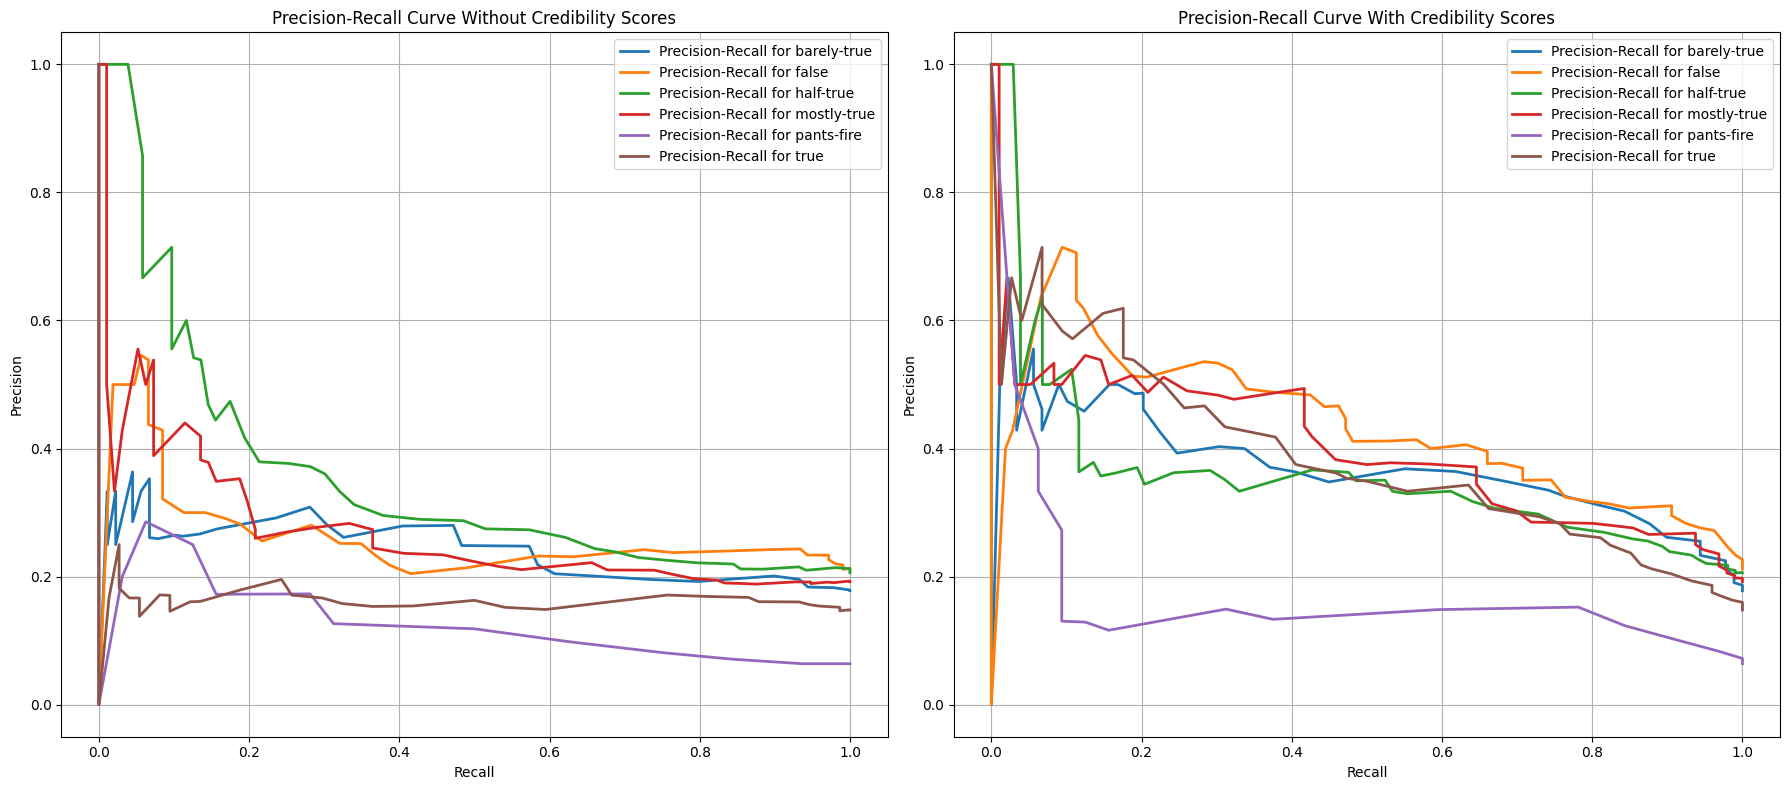

In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for the precision-recall curve
y_val_bin = label_binarize(y_val_subset, classes=classes)

# Initialize the plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot Precision-Recall curves for each class without credibility scores
axes[0].set_title('Precision-Recall Curve Without Credibility Scores')
for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_val_bin[:, i], rf_classifier.predict_proba(X_val_tfidf)[:, i])
    axes[0].plot(recall, precision, lw=2, label=f'Precision-Recall for {class_label}')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend(loc='best')
axes[0].grid()

# Plot Precision-Recall curves for each class with credibility scores
axes[1].set_title('Precision-Recall Curve With Credibility Scores')
for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_val_bin[:, i], rf_classifier_with_scores.predict_proba(X_val_tfidf_with_scores)[:, i])
    axes[1].plot(recall, precision, lw=2, label=f'Precision-Recall for {class_label}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='best')
axes[1].grid()

# Display the plot
plt.tight_layout()
plt.show()


The integration of credibility scores leads to a notable improvement in the model’s precision across all classes, particularly at higher recall levels. This enhancement demonstrates the effectiveness of credibility scores in refining the model's predictions, reducing false positives, and boosting confidence in correctly classified instances. These results strongly support the conclusion that incorporating credibility scores not only enhances the accuracy of fake news detection but also contributes to more reliable and context-aware decision-making.


### Confusion Matrix Comparison

This step presents a detailed comparison of the models' performance using confusion matrices. The first two heatmaps display the classification results for the baseline and enhanced models, respectively. The third heatmap shows the difference between these matrices, highlighting the specific areas where the model's performance improved or declined with the integration of credibility scores. Positive values in the difference matrix indicate improvements, while negative values suggest declines. This visualization offers a clear perspective on how credibility scores influence the model’s classification accuracy across different classes.


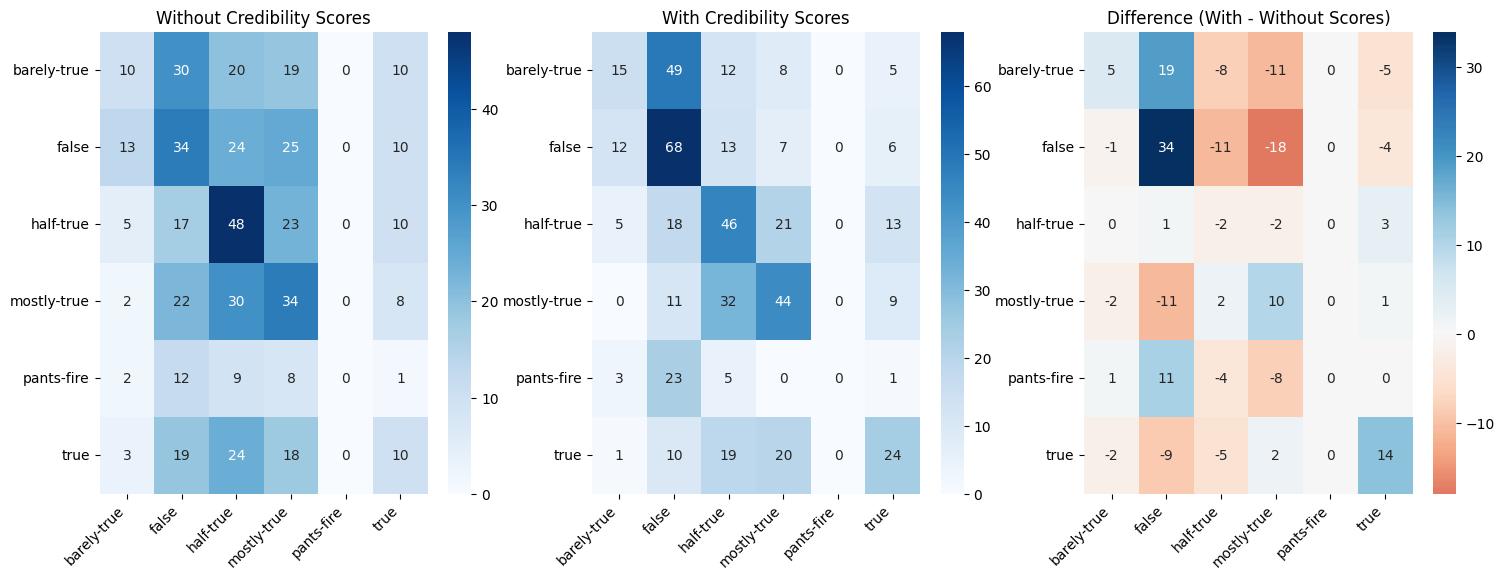

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrices
conf_matrix_without = confusion_matrix(y_val_subset, y_val_pred, labels=classes)
conf_matrix_with = confusion_matrix(y_val_subset, y_val_pred_with_scores, labels=classes)

# Calculate the difference matrix
diff_matrix = conf_matrix_with - conf_matrix_without

# Display the confusion matrices as heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(conf_matrix_without, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Without Credibility Scores")
axes[0].set_xticklabels(classes, rotation=45, ha="right")
axes[0].set_yticklabels(classes, rotation=0)  # Set y labels horizontally

sns.heatmap(conf_matrix_with, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("With Credibility Scores")
axes[1].set_xticklabels(classes, rotation=45, ha="right")
axes[1].set_yticklabels(classes, rotation=0)  # Set y labels horizontally

sns.heatmap(diff_matrix, annot=True, fmt="d", cmap="RdBu", center=0, ax=axes[2])
axes[2].set_title("Difference (With - Without Scores)")
axes[2].set_xticklabels(classes, rotation=45, ha="right")
axes[2].set_yticklabels(classes, rotation=0)  # Set y labels horizontally

plt.show()


---

## 6. Model Interpretability

### Using SHAP (SHapley Additive exPlanations)

Having developed and evaluated our models, the final step focuses on enhancing interpretability. We employ SHAP (SHapley Additive exPlanations) to provide clear insights into the factors driving model predictions. This approach not only helps validate model behavior but also aligns with our objective of ensuring transparency alongside accuracy.

In this section, we initialize SHAP explainers for both the baseline and enhanced models. We then compute SHAP values, which will be used to visualize and interpret the impact of individual features on our predictions, including the credibility scores.


In [23]:
import shap

# Initialize JavaScript visualization in Jupyter Notebook
shap.initjs()

# Initialize the SHAP explainer with dense training data
rf_explainer = shap.TreeExplainer(rf_classifier, X_train_tfidf_dense)
rf_explainer_with_scores = shap.TreeExplainer(rf_classifier_with_scores, X_train_tfidf_dense_with_scores)

# Generate SHAP values for the validation data
rf_shap_values = rf_explainer.shap_values(X_train_tfidf_dense)
rf_shap_values_with_scores = rf_explainer_with_scores.shap_values(X_train_tfidf_dense_with_scores)


 99%|===================| 2972/3000 [00:29<00:00]        

### SHAP Analysis for Model Interpretability

After initializing SHAP explainers and computing SHAP values, we now turn to the detailed analysis of individual sample predictions. In this section, we apply SHAP to a subset of validation samples to compare the baseline model and the enhanced model with credibility scores. This comparison highlights how different features contribute to each prediction and allows us to visually assess the impact of incorporating credibility scores.

This step iterates through a selected set of samples, displaying relevant data, model predictions, actual labels, and SHAP force plots. This process provides a clear, interpretable view of how the models arrive at their decisions, reinforcing the transparency and explainability that are central to our approach.


In [24]:
import shap
import pandas as pd
from IPython.display import display, HTML

# Initialize SHAP visualization
shap.initjs()

# Define the number of samples to analyze
rf_num_samples = 10
rf_sample_indices = range(rf_num_samples)

# Generate predictions and SHAP values for both models
rf_sample_predictions = rf_classifier.predict(X_val_tfidf[rf_sample_indices])
rf_sample_shap_values = rf_explainer.shap_values(X_val_tfidf_dense[rf_sample_indices])
rf_sample_predictions_with_scores = rf_classifier_with_scores.predict(X_val_tfidf_with_scores[rf_sample_indices])
rf_sample_shap_values_with_scores = rf_explainer_with_scores.shap_values(X_val_tfidf_dense_with_scores[rf_sample_indices])

# Function to display results and SHAP plots
def display_sample_info(index, prediction, shap_values, shap_explainer, data, feature_names, include_all_columns=True):
    row = X_val_subset.iloc[index]
    columns = list(row.index) + ['Prediction', 'Actual Label']
    values = list(row.values) + [prediction, y_val_subset.iloc[index]]

    sample_df = pd.DataFrame([values], columns=columns)

    # Highlight predictions and actual labels
    styled_df = sample_df.style.applymap(lambda x: 'background-color: #ffff99' if x in [prediction, y_val_subset.iloc[index]] else '', subset=['Prediction', 'Actual Label']).hide(axis="index")
    display(styled_df)

    # SHAP Force Plot
    display(shap.force_plot(shap_explainer.expected_value[1], shap_values[1][index], data[index], feature_names=feature_names))

# Iterate over sample indices and display information
for i in rf_sample_indices:
    display_sample_info(i, rf_sample_predictions[i], rf_sample_shap_values, rf_explainer, X_val_tfidf_dense, tfidf_feature_names)
    display_sample_info(i, rf_sample_predictions_with_scores[i], rf_sample_shap_values_with_scores, rf_explainer_with_scores, X_val_tfidf_dense_with_scores, tfidf_feature_names_with_scores)

    # Separator for readability between samples
    display(HTML("<div style='text-align: center; font-weight: bold; font-size: 20px;'>{}<div>".format("="*80)))


### Comparing Feature Importance with SHAP Summary Plots

In this section, we visualize the feature importance for both the baseline model (using only TF-IDF features) and the enhanced model (with added credibility scores). By generating separate SHAP summary plots for each model, we can clearly observe which features contribute most to the predictions in each case. The bar plot format provides an intuitive view of the average impact of each feature across all classes.


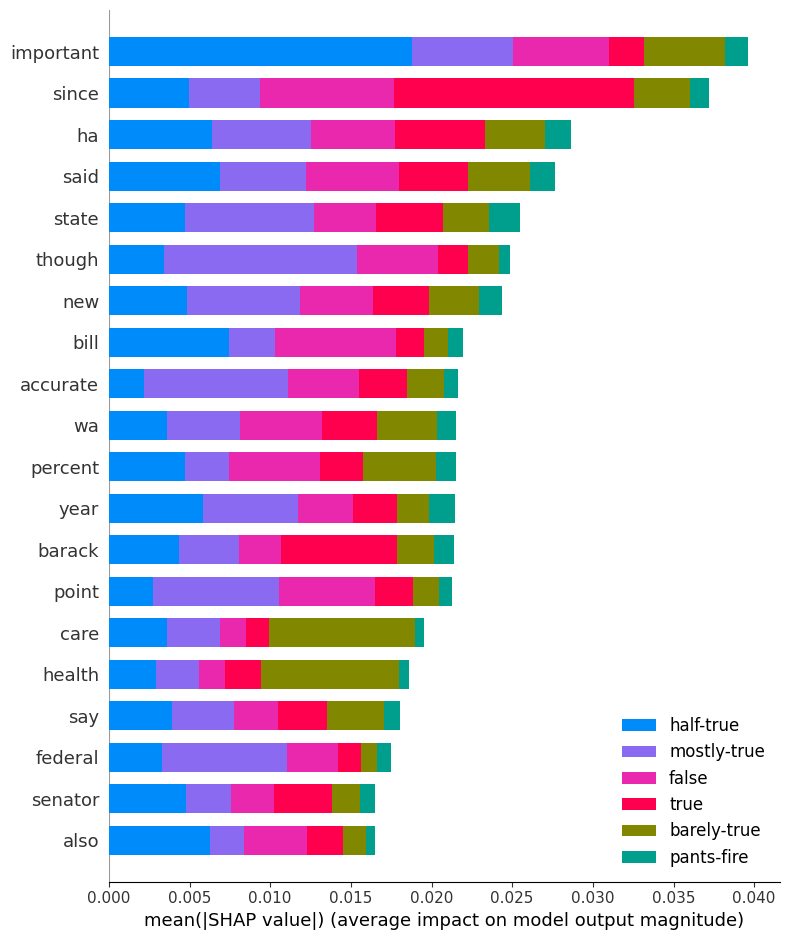

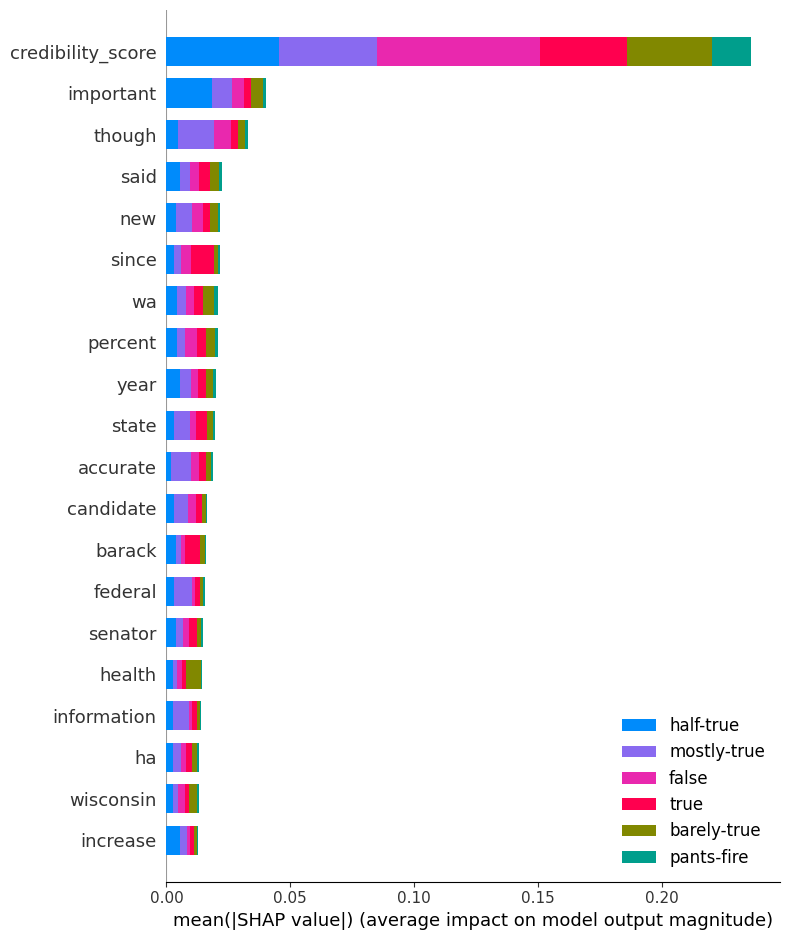

In [25]:
shap.summary_plot(rf_shap_values, X_val_tfidf_dense, plot_type='bar', feature_names=tfidf_feature_names, class_names=classes)
shap.summary_plot(rf_shap_values_with_scores, X_val_tfidf_dense_with_scores, plot_type='bar', feature_names=tfidf_feature_names_with_scores, class_names=classes)


The integration of credibility scores into the fake news detection model has led to a substantial improvement in both accuracy and interpretability. The SHAP analysis highlights a significant shift in feature importance, with the `credibility_score` emerging as the most influential factor. This shift indicates that the enhanced model is more contextually aware, using the historical reliability of sources to make more informed predictions.

While the credibility score now dominates, the model still effectively incorporates key textual features, ensuring that content remains a vital part of the decision-making process. This balanced approach reflects the success of the implementation, demonstrating that combining source credibility with traditional text analysis creates a more robust and interpretable model. Overall, the results strongly support the effectiveness of the methodology in improving fake news detection.

That said, the dominance of the credibility score raises an important consideration. While this feature greatly enhances context-awareness, it could lead to an over-reliance on the source’s historical behavior, potentially overshadowing the content’s actual value. Ensuring a balanced influence between credibility and content-specific features will be crucial for maintaining the model’s robustness across varied scenarios.


### Feature Interaction Analysis with SHAP Dependence Plots

In this section, we generate SHAP dependence plots to analyze how a specific feature (e.g. 'obama'), influences predictions across different classes. The process involves iterating through each class and creating a plot that shows the relationship between this feature and the model's SHAP values. This analysis helps us understand how the presence of 'obama' impacts the model's decision-making, while also considering its interaction with another feature, 'care'.

Each class's dependence plot provides visual insight into the model's behavior, highlighting how different classes respond to the feature. By examining these plots, we gain a deeper understanding of the model's inner workings, ensuring that predictions are both accurate and interpretable.


Dependence plot for class: barely-true


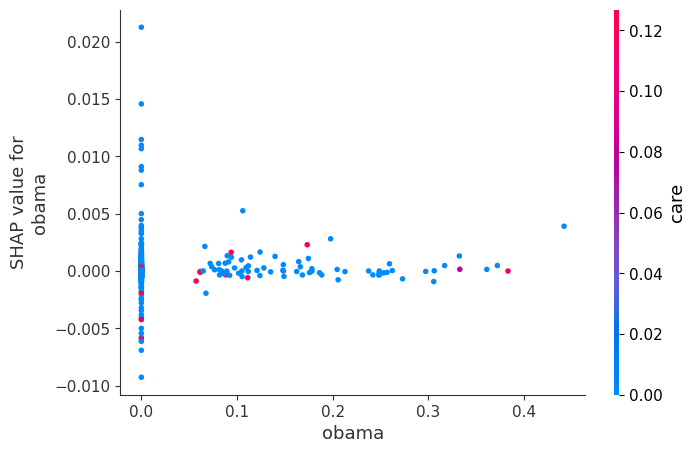

Dependence plot for class: false


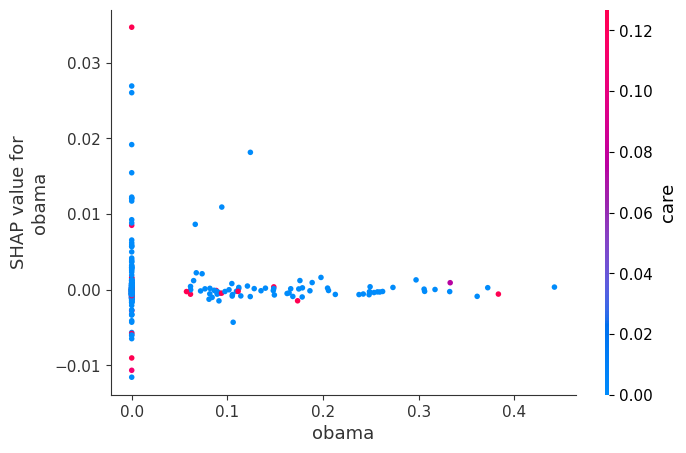

Dependence plot for class: half-true


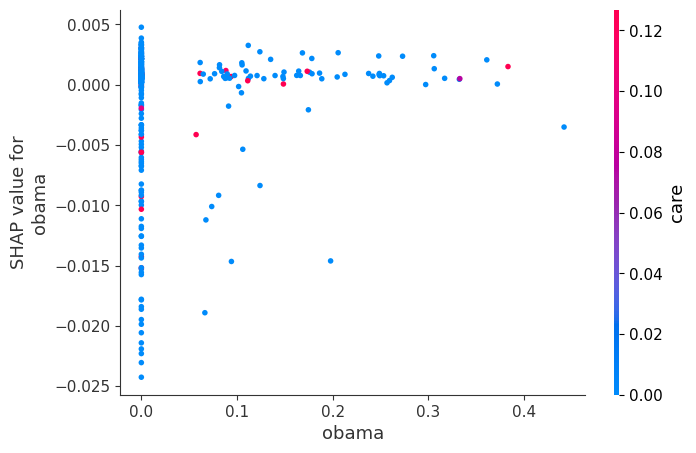

Dependence plot for class: mostly-true


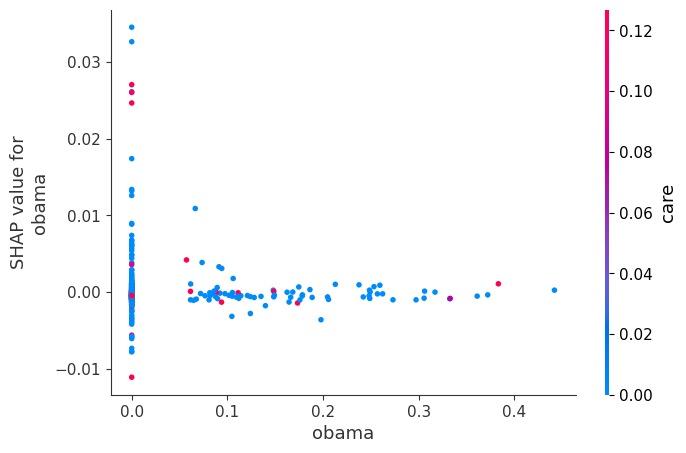

Dependence plot for class: pants-fire


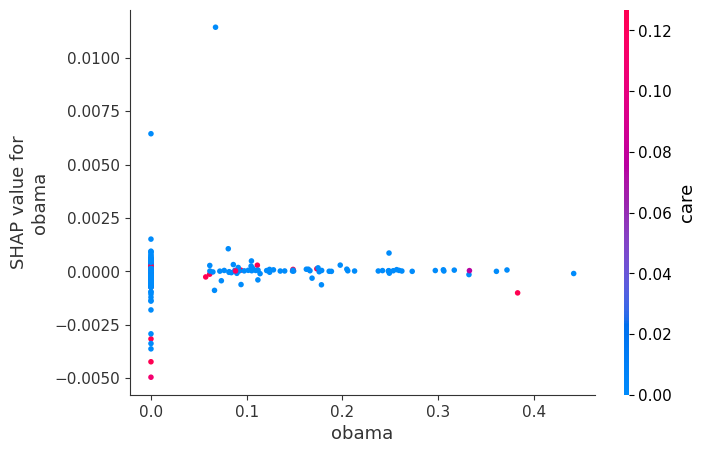

Dependence plot for class: true


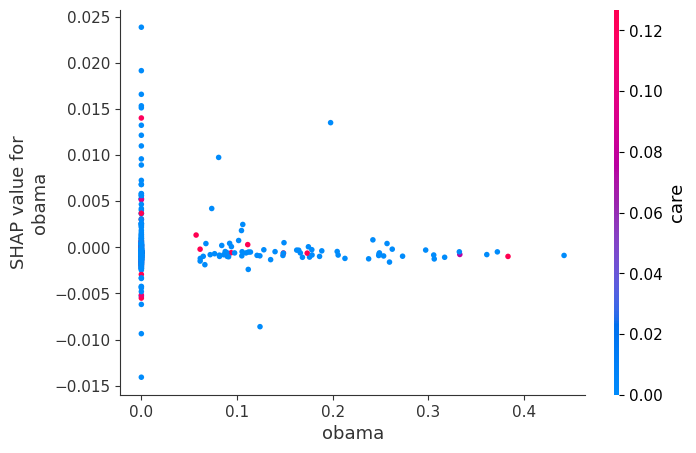

In [26]:
# Example feature name for the dependence plot
feature_name = 'obama'

# Loop through each class to create dependence plots
for class_idx, class_name in enumerate(classes):
    print(f"Dependence plot for class: {class_name}")
    shap.dependence_plot(feature_name, rf_shap_values_with_scores[class_idx], X_val_tfidf_dense_with_scores, feature_names=tfidf_feature_names_with_scores, interaction_index="care")


### Generating SHAP Summary Plots for Each Class

To further delve into the specifics of how different features influence the predictions of various truthfulness categories in our model, we employ SHAP summary plots. These visualizations are created for each class to display the aggregate importance of each feature and the distribution of their effects. Below we iteratively generate both bar and dot SHAP summary plots for each truthfulness category:


Summary Bar Plot for class: barely-true


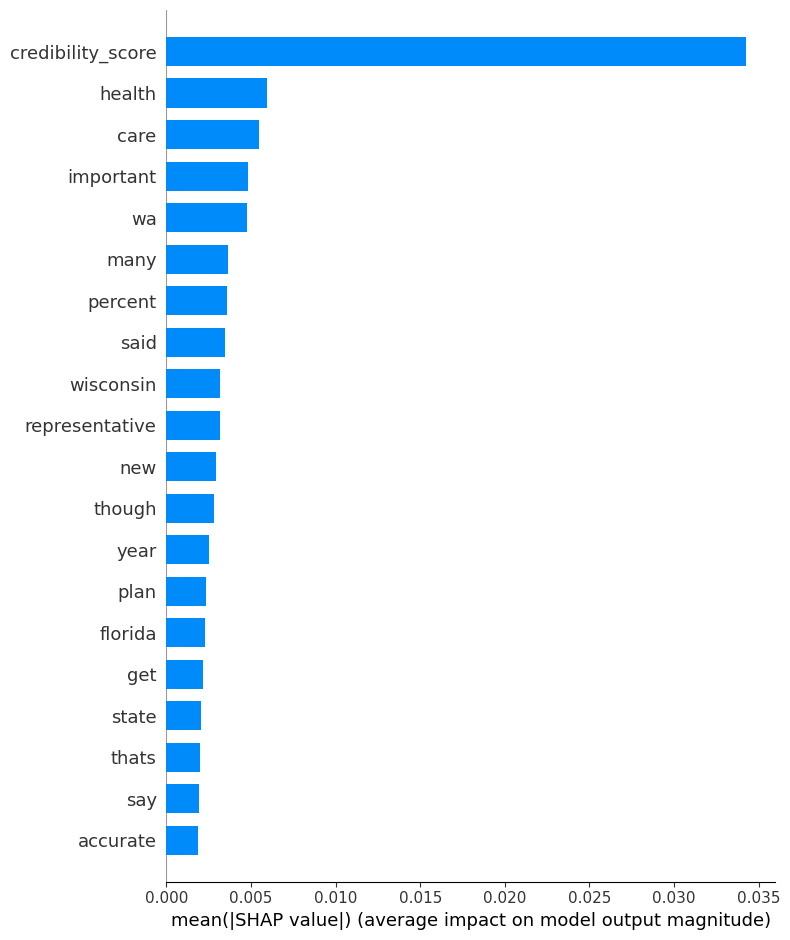

Summary plot for class: barely-true


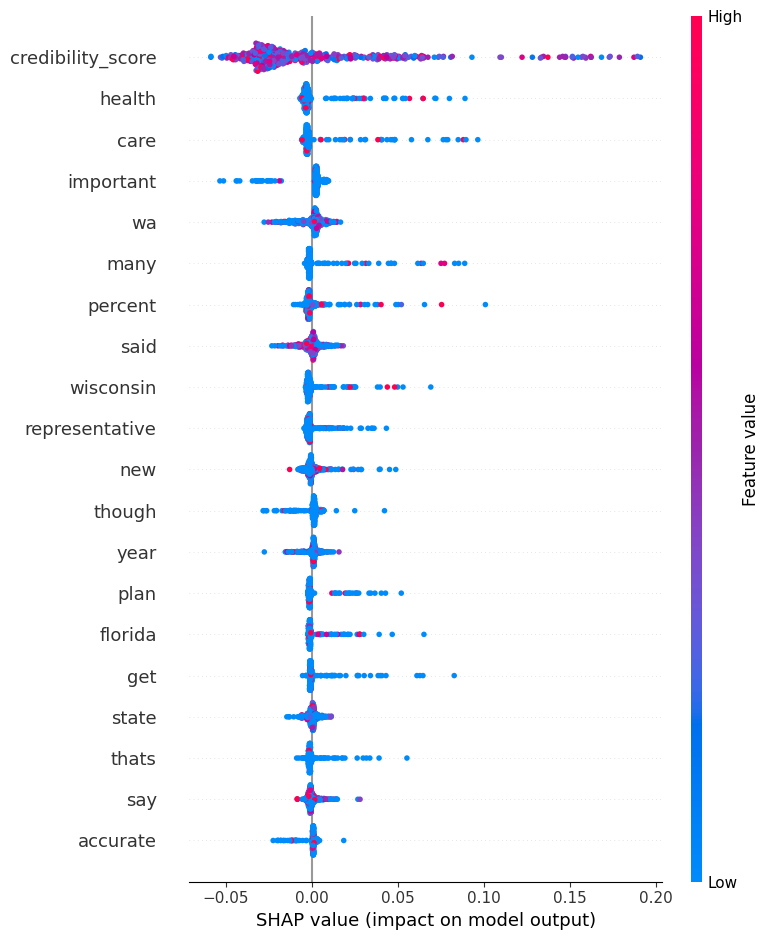

Summary Bar Plot for class: false


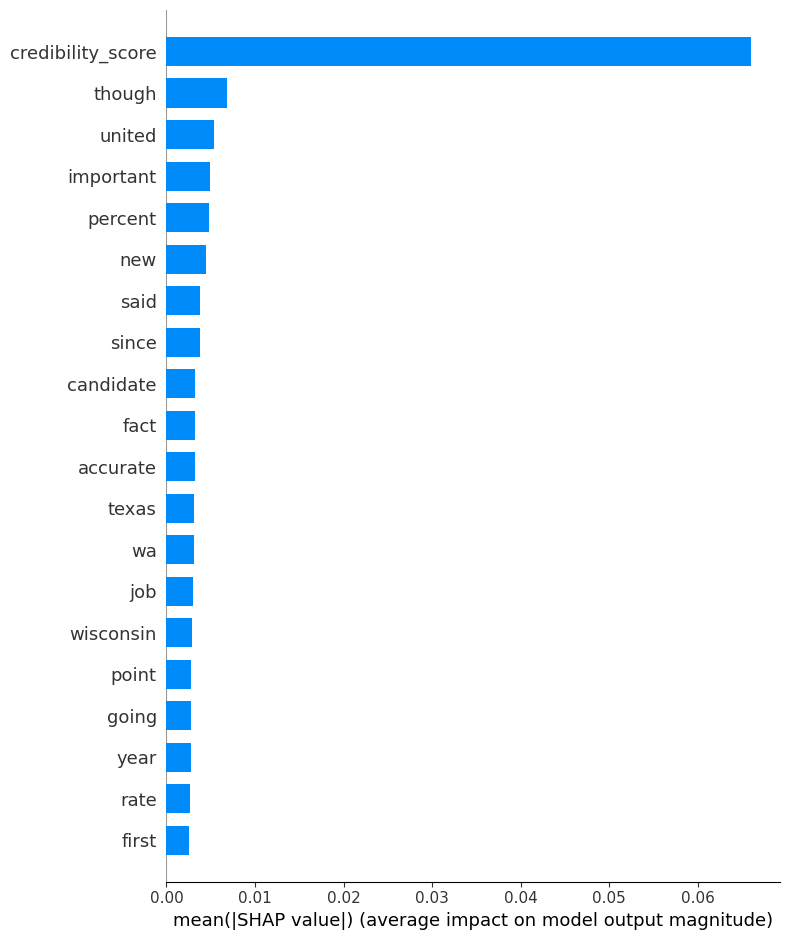

Summary plot for class: false


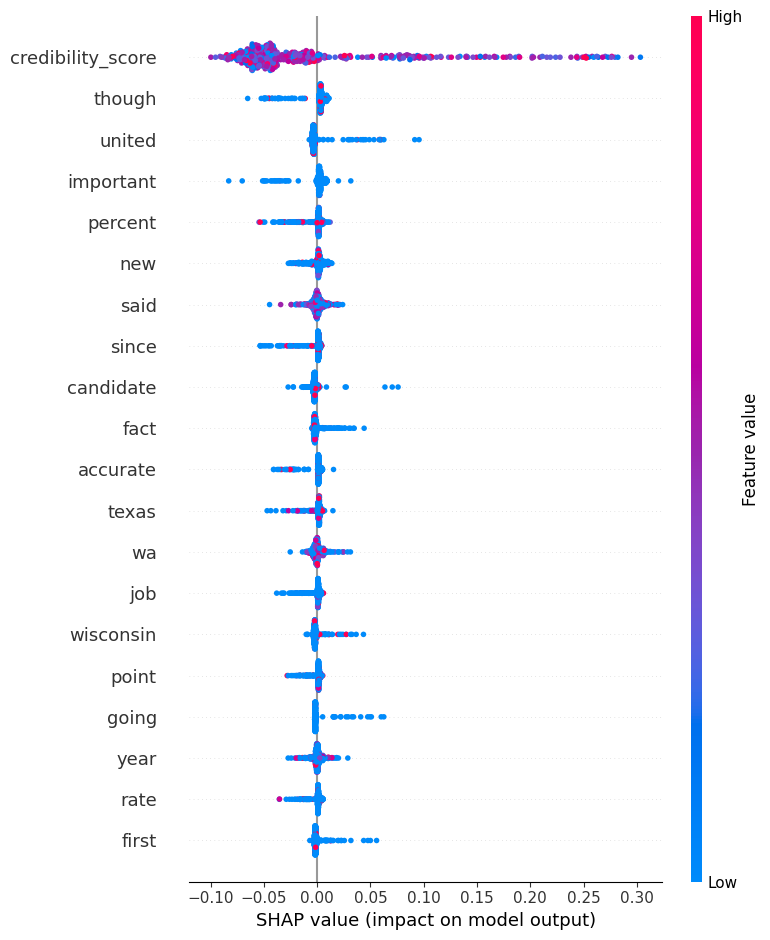

Summary Bar Plot for class: half-true


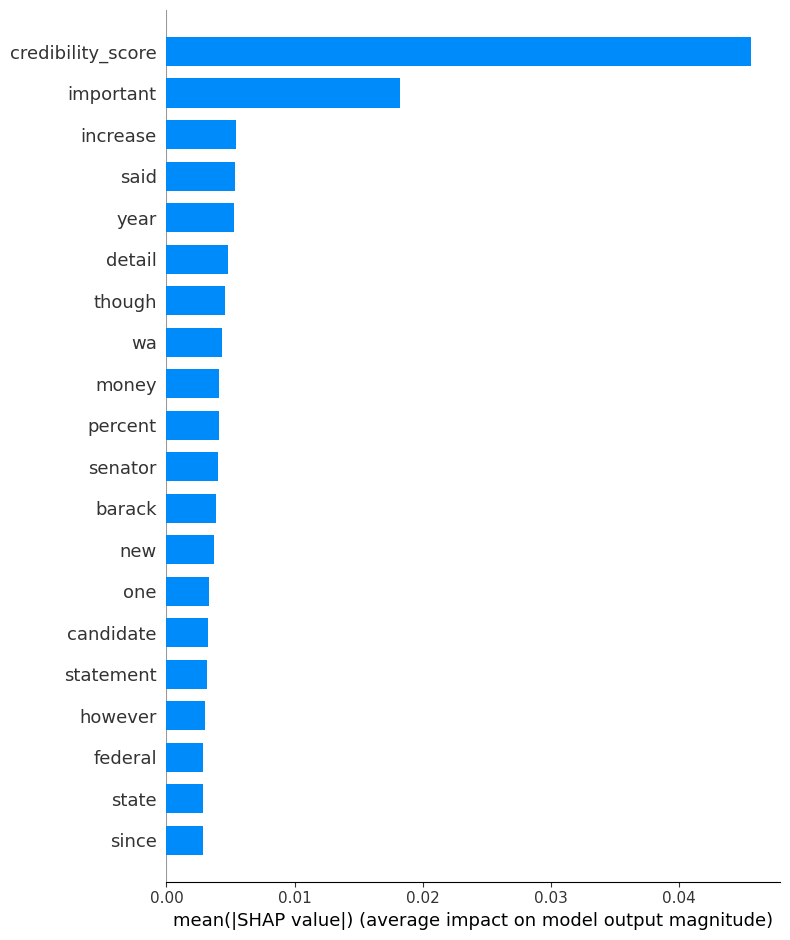

Summary plot for class: half-true


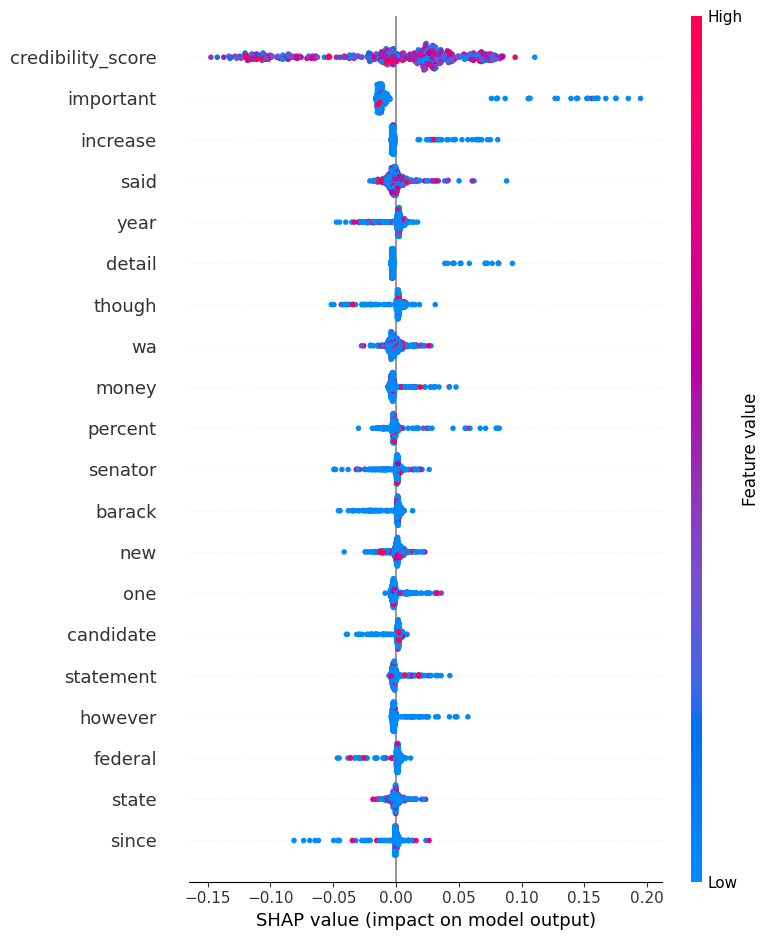

Summary Bar Plot for class: mostly-true


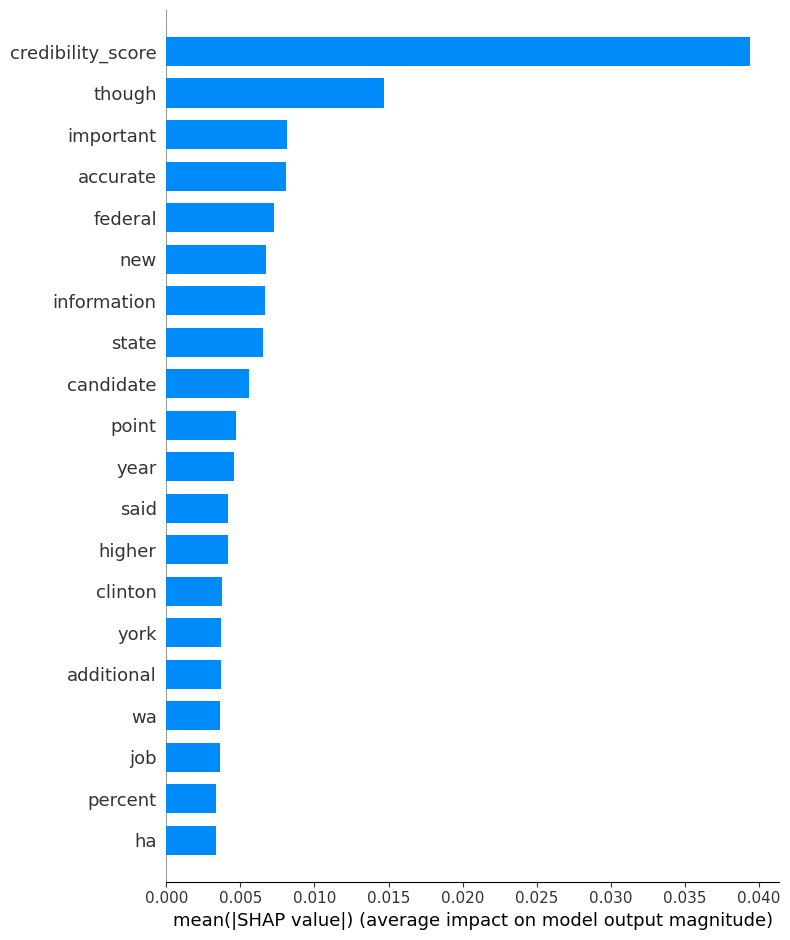

Summary plot for class: mostly-true


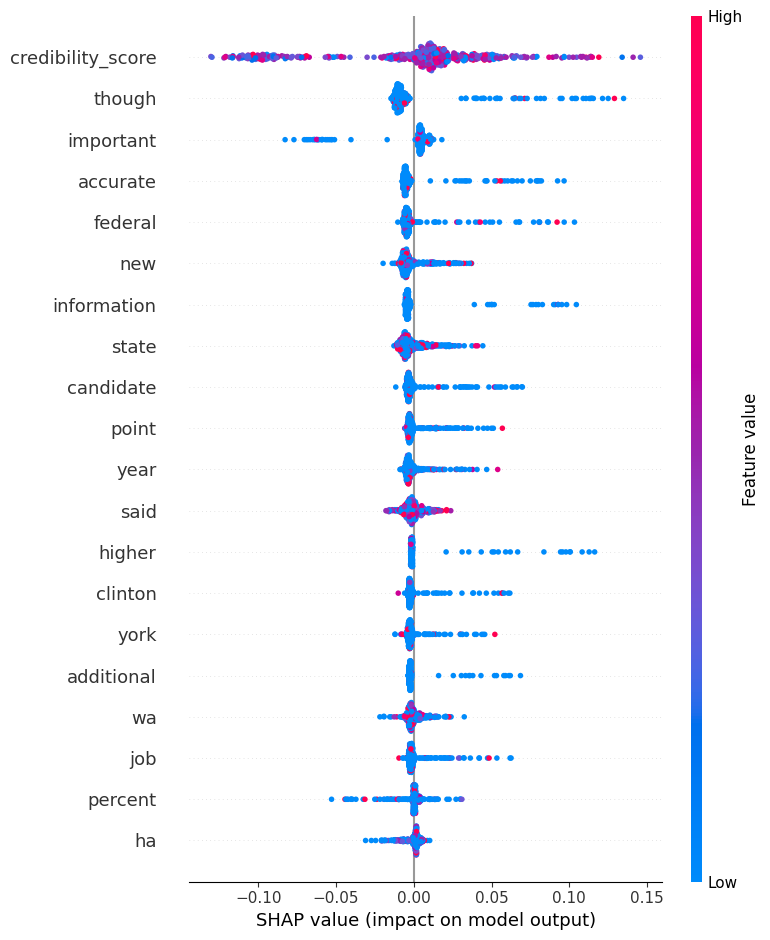

Summary Bar Plot for class: pants-fire


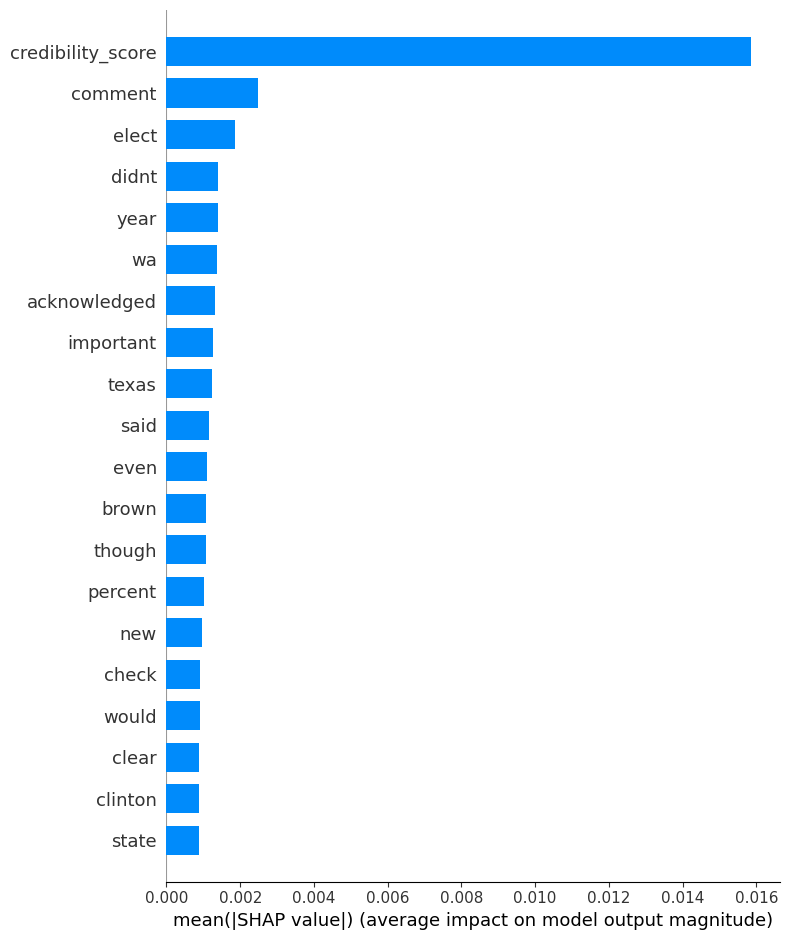

Summary plot for class: pants-fire


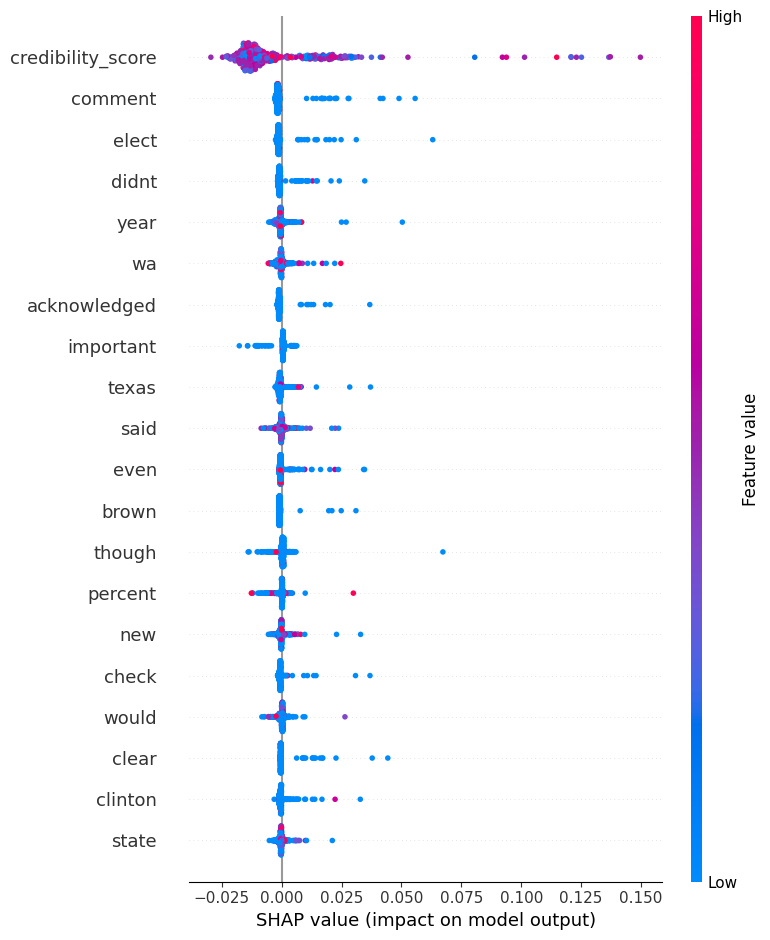

Summary Bar Plot for class: true


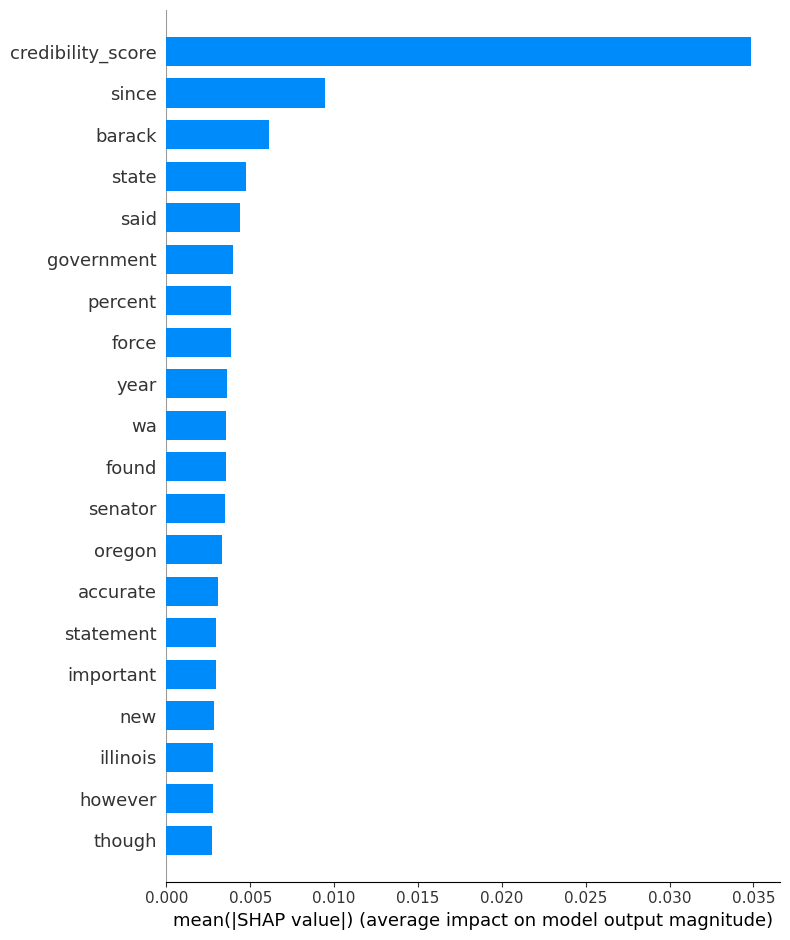

Summary plot for class: true


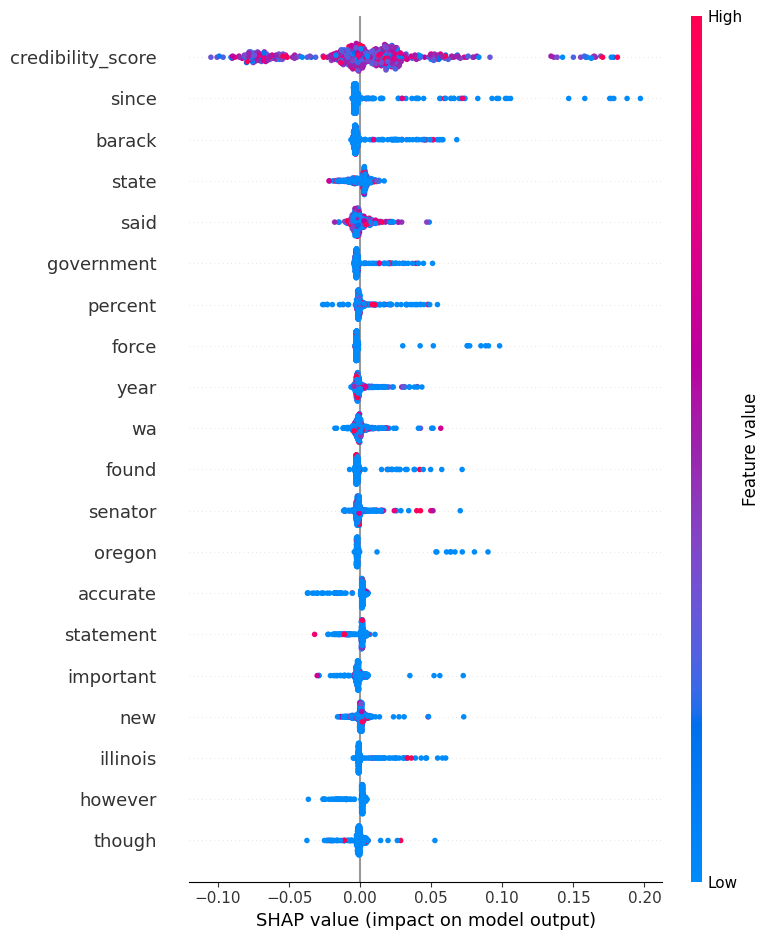

In [27]:
# Create the SHAP summary dot plot for each class
for class_idx, class_name in enumerate(classes):
    print(f"Summary Bar Plot for class: {class_name}")
    shap.summary_plot(rf_shap_values_with_scores[class_idx], X_val_tfidf_dense_with_scores, feature_names=tfidf_feature_names_with_scores, plot_type="bar", class_names=[class_name])

    print(f"Summary plot for class: {class_name}")
    shap.summary_plot(rf_shap_values_with_scores[class_idx], X_val_tfidf_dense_with_scores, feature_names=tfidf_feature_names_with_scores, class_names=classes, plot_type="dot")


**Explanation of SHAP Summary Plots:**

- **Bar Plot:** This visualization ranks features by their overall impact on the model's output for a specific class. Each bar represents the mean absolute SHAP value of a feature, providing a clear view of which features are most influential for the class in question.

- **Dot Plot:** Unlike the bar plot, the dot plot displays the distribution and impact of SHAP values for each feature on an individual sample basis. It shows both the positive and negative influences of features on the model's prediction, giving insight into the variability and consistency of feature impacts across the dataset.

Creating SHAP summary plots for each class allows us to understand the nuanced contributions of features to different categories of predictions. Bar plots provide a straightforward ranking of feature importance, while dot plots offer a detailed look at how each feature's impact varies among individual predictions. These visualizations are essential tools for interpreting complex model behaviors, enhancing transparency, and guiding model refinement to improve performance and fairness.
